# Benchmark: Manns Lab data

In this notebook, we will explore a bulk MS human patient dataset containing protein intensities.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import manns_lab_support as sup
from scp.models import PROTVI

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s define the paths.

In [2]:
MAIN_ANNOTATIONS_PATH = "../data/manns_lab/MAIN/annotations_main_lt_v21_Sc11_AIMsplit3.tsv"
MAIN_DATA_PATH = "../data/manns_lab/MAIN/DA-F08.4_-SEC-pass_v06Sc_ion_LibPGQVal1perc_precdLFQdefFull_prot_preprSc03.tsv"

## Data Exploration

Let"s load the data.

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata = sup.load_main_data(MAIN_DATA_PATH, MAIN_ANNOTATIONS_PATH)
    adata = sup.preprocess(adata)

input: (5045, 2703)
sc.pp.filter_genes: (5045, 2703)
sc.pp.filter_cells: (5045, 2703)
filter: (4566, 2018)


After filtering the data, we end up with:

In [4]:
adata

AnnData object with n_obs × n_vars = 4566 × 2018
    obs: 'Run', 'Experiment', 'Sex', 'Age', 'MSgroup', 'Diagnosis_group', 'Diagnosis_group_subtype', 'Diagnosis_group_autoimmune_split', 'RMS_PMS', 'Plate', 'Preparation day', 'Sample_position', 'Sample_row', 'Sample_column', 'Leukocyte count', 'Leukocyte_count_log2', 'Erythrocytes', 'Total protein', 'Total_protein_log2', 'Albumin CSF', 'Albumin_CSF_log2', 'Qalb', 'QAlb_log2', 'Diff_age_adj_QAlb', 'Diff_age_adj_QAlb_log2', 'IgG CSF', 'IgG_CSF_log2', 'QIgG', 'QIgG_log2', 'Sample_injection_number', 'Sample_injection_order', 'Sample_plate_order', 'Sample_plate_order_inCrossSectional', 'Depth_PG', 'Depth_Gene', 'EvoSep', 'LC_column', 'Emitter', 'Capillary', 'MS_calibration', 'Evosept', 'Column', 'Maintenance', 'log Qalb', 'n_genes'
    var: 'Protein.Group', 'UniProtID_forAnnotationMatch', 'Entry.Name', 'Genes', 'AnnotationFile_Entry', 'Protein.Names', 'Organism', 'Mass', 'Keywords', 'GOBP', 'GOCC', 'GOMF', 'Protein.Family', 'Glycosylated', '

In the intensity-based expression matrix. Each obs is a patient and each "var" is a protein.

**Selected patient specific attributes:**
* Diagnosis_group: the diagnosis of the patient
* Qalb  and IgG CSF: Serum quotient of albumin (Qalb) and the cerebrospinal fluid (CSF) are the most used biomarker for the evaluation of blood–cerebrospinal fluid barrier (B-CSF-B) permeability. They are age- and sex-related.
* Platte: the plate identifier


In [5]:
adata.obs.head()

,Run,Experiment,Sex,Age,MSgroup,Diagnosis_group,Diagnosis_group_subtype,Diagnosis_group_autoimmune_split,RMS_PMS,Plate,...,EvoSep,LC_column,Emitter,Capillary,MS_calibration,Evosept,Column,Maintenance,log Qalb,n_genes
ID,,,,,,,,,,,,,,,,,,,,,
01_A_03,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,24.0,nonMS,Headache,NaN,Headache,NaN,plate1,...,E1,C1,1,1,M01,1,1,01,1.547563,1601
01_A_04,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,53.0,nonMS,Neurodegenerative,NaN,Neurodegenerative,NaN,plate1,...,E1,C1,1,1,M01,1,1,01,1.526056,1694
01_A_05,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,55.0,nonMS,Other,NaN,Other,NaN,plate1,...,E1,C1,1,1,M01,1,1,01,2.292535,1516
01_A_06,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,33.0,nonMS,Other,NaN,Other,NaN,plate1,...,E1,C1,1,1,M01,1,1,01,1.974081,1572
01_A_07,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,26.0,MS,MS,RMS,MS,RMS,plate1,...,E1,C1,1,1,M01,1,1,01,1.410987,1521


Let"s look at the distribution of some of the patient features.

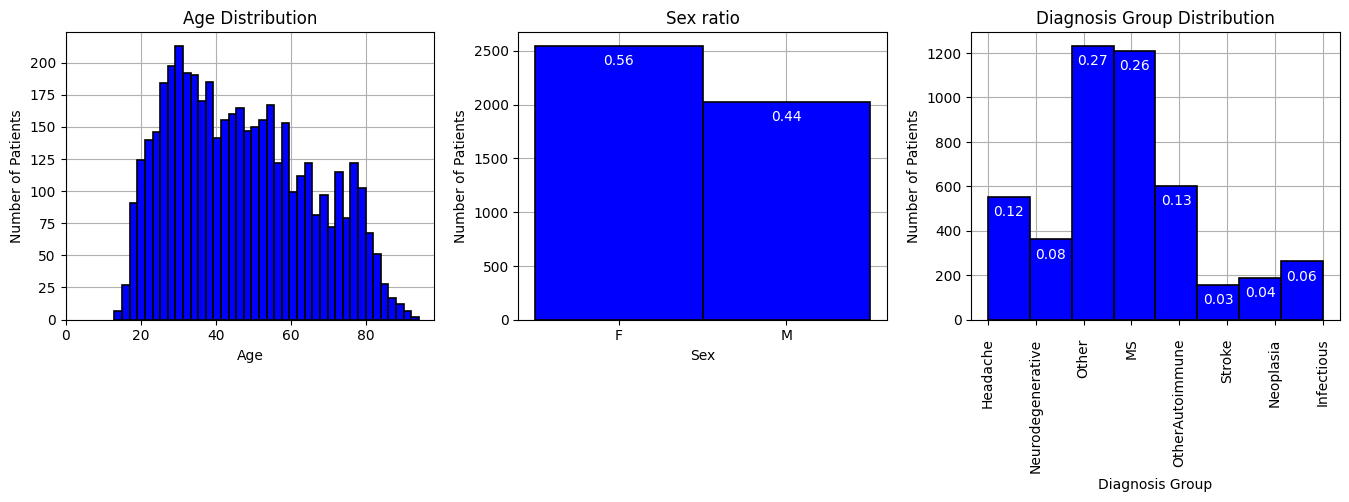

In [6]:
fig, axes = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
fig.tight_layout(pad=3.0)

# age
ax = axes[0]
ax.hist(adata.obs["Age"], bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Age")
ax.set_ylabel("Number of Patients")
ax.set_title("Age Distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

# sex
ax = axes[1]
ax.hist(adata.obs["Sex"], bins=2, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Sex")
ax.set_ylabel("Number of Patients")
ax.set_title("Sex ratio")
ax.set_xticks([0.25, 0.75])
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 200, f"{height / len(adata.obs):.2f}", ha="center", va="bottom", color="white")

# diagnosis group
ax = axes[2]
N_bins = len(adata.obs["Diagnosis_group"].unique())
ax.hist(adata.obs["Diagnosis_group"], bins=N_bins, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Diagnosis Group")
ax.set_ylabel("Number of Patients")
ax.set_title("Diagnosis Group Distribution")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 100, f"{height / len(adata.obs):.2f}", ha="center", va="bottom", color="white")

ax.tick_params(axis="x", pad=10)
ax.grid(True)
ax.set_axisbelow(True)


Recall, the biomarkers are age related. Let's see if that is true for this dataset.

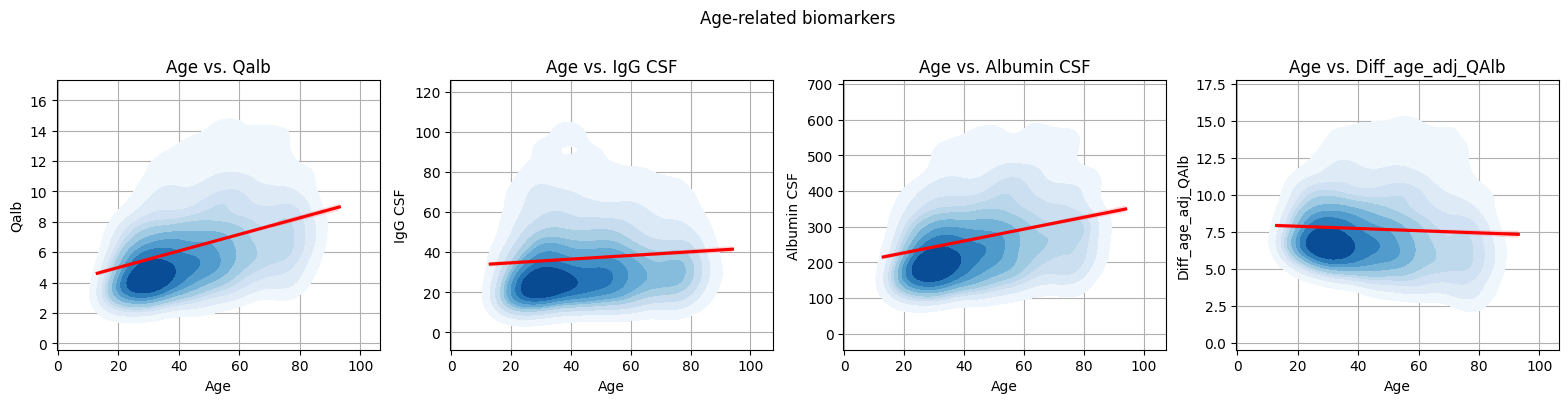

In [41]:
biomarkers = ["Qalb", "IgG CSF", "Albumin CSF", "Diff_age_adj_QAlb"]

N_cols = len(biomarkers)

fig, axes = plt.subplots(ncols=N_cols, nrows=1, figsize=(16, 4))
fig.suptitle("Age-related biomarkers")
fig.tight_layout(pad=2.0)

for i, biomarker in enumerate(biomarkers):
    subset = adata[adata.obs[biomarker] < adata.obs[biomarker].quantile(0.95), :]
    
    ax = axes[i]
    sns.kdeplot(x=subset.obs["Age"], y=subset.obs[biomarker], cmap="Blues", shade=True, shade_lowest=False, ax=ax)
    sns.regplot(x=subset.obs["Age"], y=subset.obs[biomarker], ax=ax, scatter=False, color="red")
    ax.set_xlabel("Age")
    ax.set_ylabel(biomarker)
    ax.set_title("Age vs. {}".format(biomarker))
    ax.grid(True)

Let's check if Qalb and missingess is related.

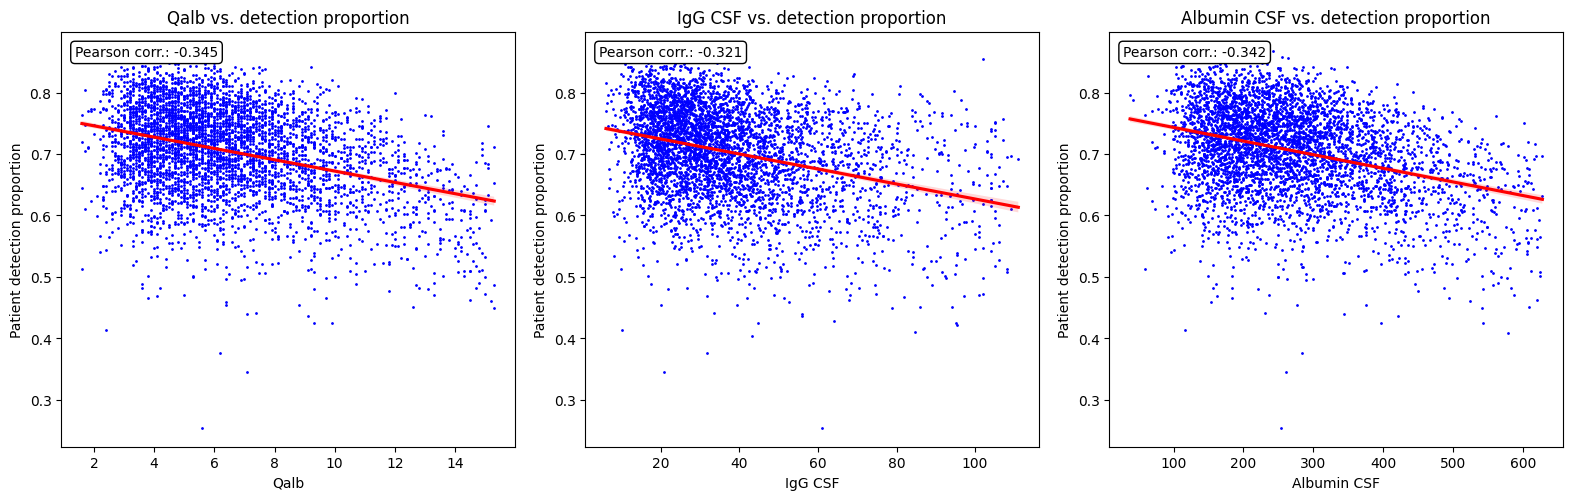

In [53]:
patient_detection_proportion = np.sum(~np.isnan(adata.X), axis=1) / adata.X.shape[1]

biomarkers = ["Qalb", "IgG CSF", "Albumin CSF"]

N_cols = len(biomarkers)

fig, axes = plt.subplots(ncols=N_cols, nrows=1, figsize=(16, 5))
fig.tight_layout(pad=2.0)

for i, biomarker in enumerate(biomarkers):
    filter = adata.obs[biomarker] < adata.obs[biomarker].quantile(0.95)
    subset = adata[filter, :]

    ax = axes[i]
    pearson_corr, _ = pearsonr(subset.obs[biomarker], patient_detection_proportion[filter])
    ax.text(0.03, 0.94, f"Pearson corr.: {pearson_corr:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)
    ax.scatter(x=subset.obs[biomarker], y=patient_detection_proportion[filter], color="blue", alpha=1, s=1)
    sns.regplot(x=subset.obs[biomarker], y=patient_detection_proportion[filter], ax=ax, scatter=False, color="red")
    
    ax.set_xlabel(biomarker)
    ax.set_ylabel("Patient detection proportion")
    ax.set_title("{} vs. detection proportion".format(biomarker))


This is correlation is not surprising as these biomarkers is related to the blood–cerebrospinal fluid barrier - a small barrier may lead to "contamination" of the CSF with blood proteins.

Let"s look at the distribution of the protein features.

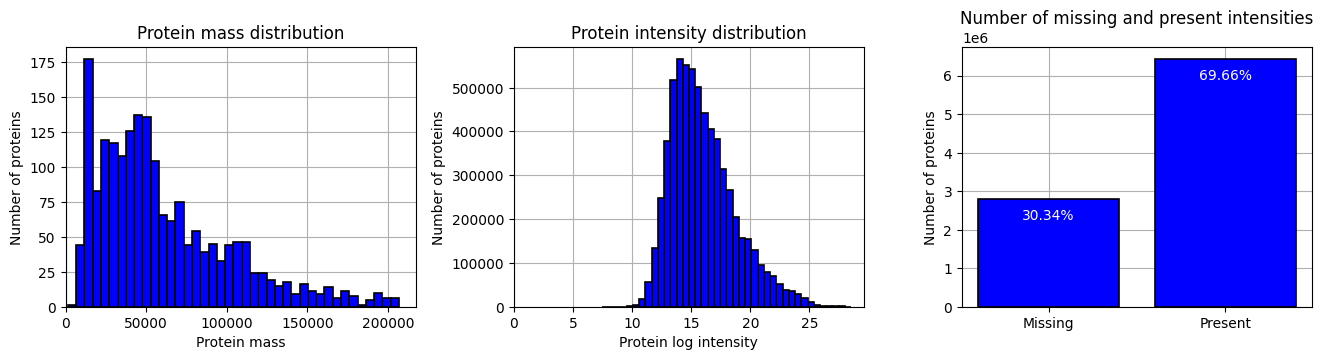

In [8]:
fig, axes = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
fig.tight_layout(pad=4.0)

ax = axes[0]
subset = adata[:, adata.var["Mass"] < adata.var["Mass"].quantile(0.95)]
ax.hist(subset.var["Mass"], bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Protein mass")
ax.set_ylabel("Number of proteins")
ax.set_title("Protein mass distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
intensities = adata.X[~np.isnan(adata.X)]
ax.hist(intensities, bins=40, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Protein log intensity")
ax.set_ylabel("Number of proteins")
ax.set_title("Protein intensity distribution")
ax.set_xlim([0, None])
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
N_missing = np.isnan(adata.X).sum()
N_present = (~np.isnan(adata.X)).sum()
N_total = N_missing + N_present
ax.bar(["Missing", "Present"], [N_missing, N_present], color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_title("Number of missing and present intensities")
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 6e5, f"{height / N_total* 100:.2f}%", ha="center", va="bottom", color="white")

Let's look at at detection probabilities given the avg. intensity for each proteins.

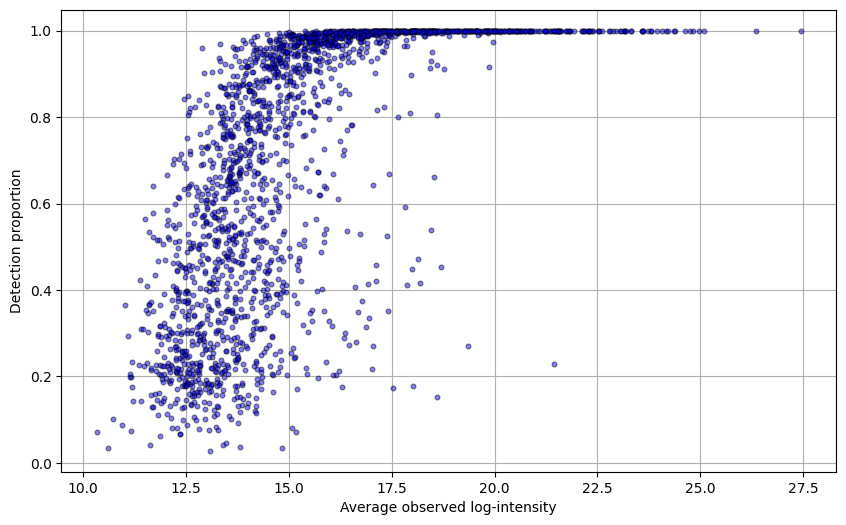

In [9]:
X_raw = adata.X

avg_protein_intensities = np.nanmean(X_raw, axis=0)
obs_detection_proportion = 1 - np.mean(np.isnan(X_raw), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(avg_protein_intensities, obs_detection_proportion, color="blue", edgecolor="black", linewidth=.8, s=12, alpha=0.5)
ax.set_xlabel("Average observed log-intensity")
ax.set_ylabel("Detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

## Modelling

In the followng section, we use the following naming convension:
- observed intensity: non-NaN intensity in the dataset.
- present intensity: intensity imputed by PROTVI, which also has a non-NaN entry in the dataset.
- missing intensity: intensity imputed by PROTVI, which also has a NaN entry in the dataset.

Let's now model the data.

In [10]:
adata.layers["missing_as_nan"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
adata.layers["missing_as_zero"] = adata.X.copy()

In [11]:
PROTVI.setup_anndata(adata, layer="missing_as_zero", batch_key="Plate")

model = PROTVI(adata, log_variational=False, n_latent=16)
#model.view_anndata_setup()

Let's train the model.

In [12]:
model.train(max_epochs=400)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [05:36<00:00,  1.15it/s, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.53e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:36<00:00,  1.19it/s, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.53e+3]


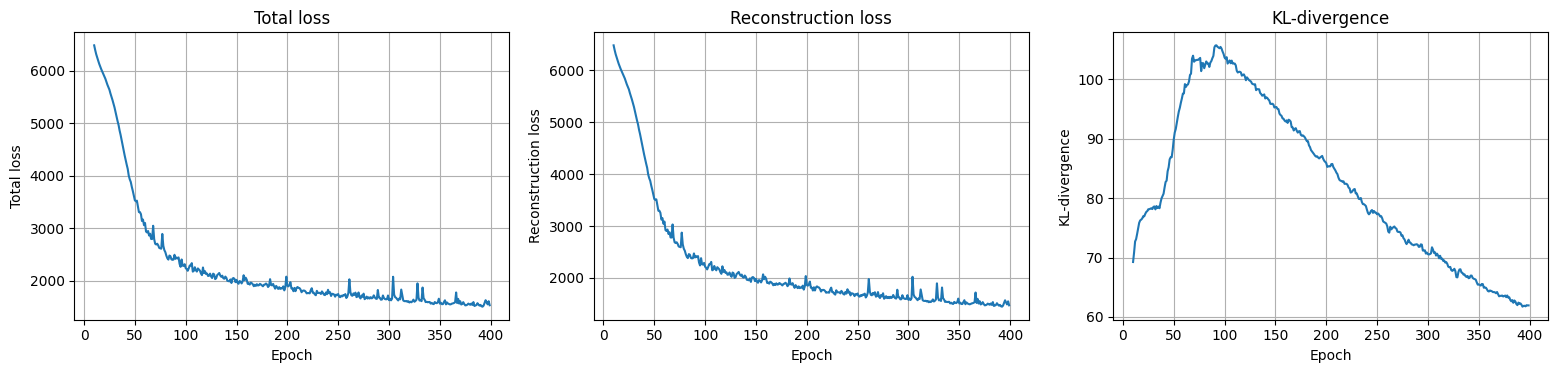

In [13]:
N_skip = 10

fig, axes = plt.subplots(figsize=(16, 4), ncols=3, nrows=1)
fig.tight_layout(pad=3)

ax = axes[0]
ax.plot(model.history["train_loss_epoch"].iloc[N_skip:])
ax.set_xlabel("Epoch")
ax.set_ylabel("Total loss")
ax.set_title("Total loss")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.plot(model.history["reconstruction_loss_train"].iloc[N_skip:])
ax.set_xlabel("Epoch")
ax.set_ylabel("Reconstruction loss")
ax.set_title("Reconstruction loss")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
ax.plot(model.history["kl_local_train"].iloc[N_skip:])
ax.set_xlabel("Epoch")
ax.set_ylabel("KL-divergence")
ax.set_title("KL-divergence")
ax.grid(True)
ax.set_axisbelow(True)

Let's look at the latent space.

In [14]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

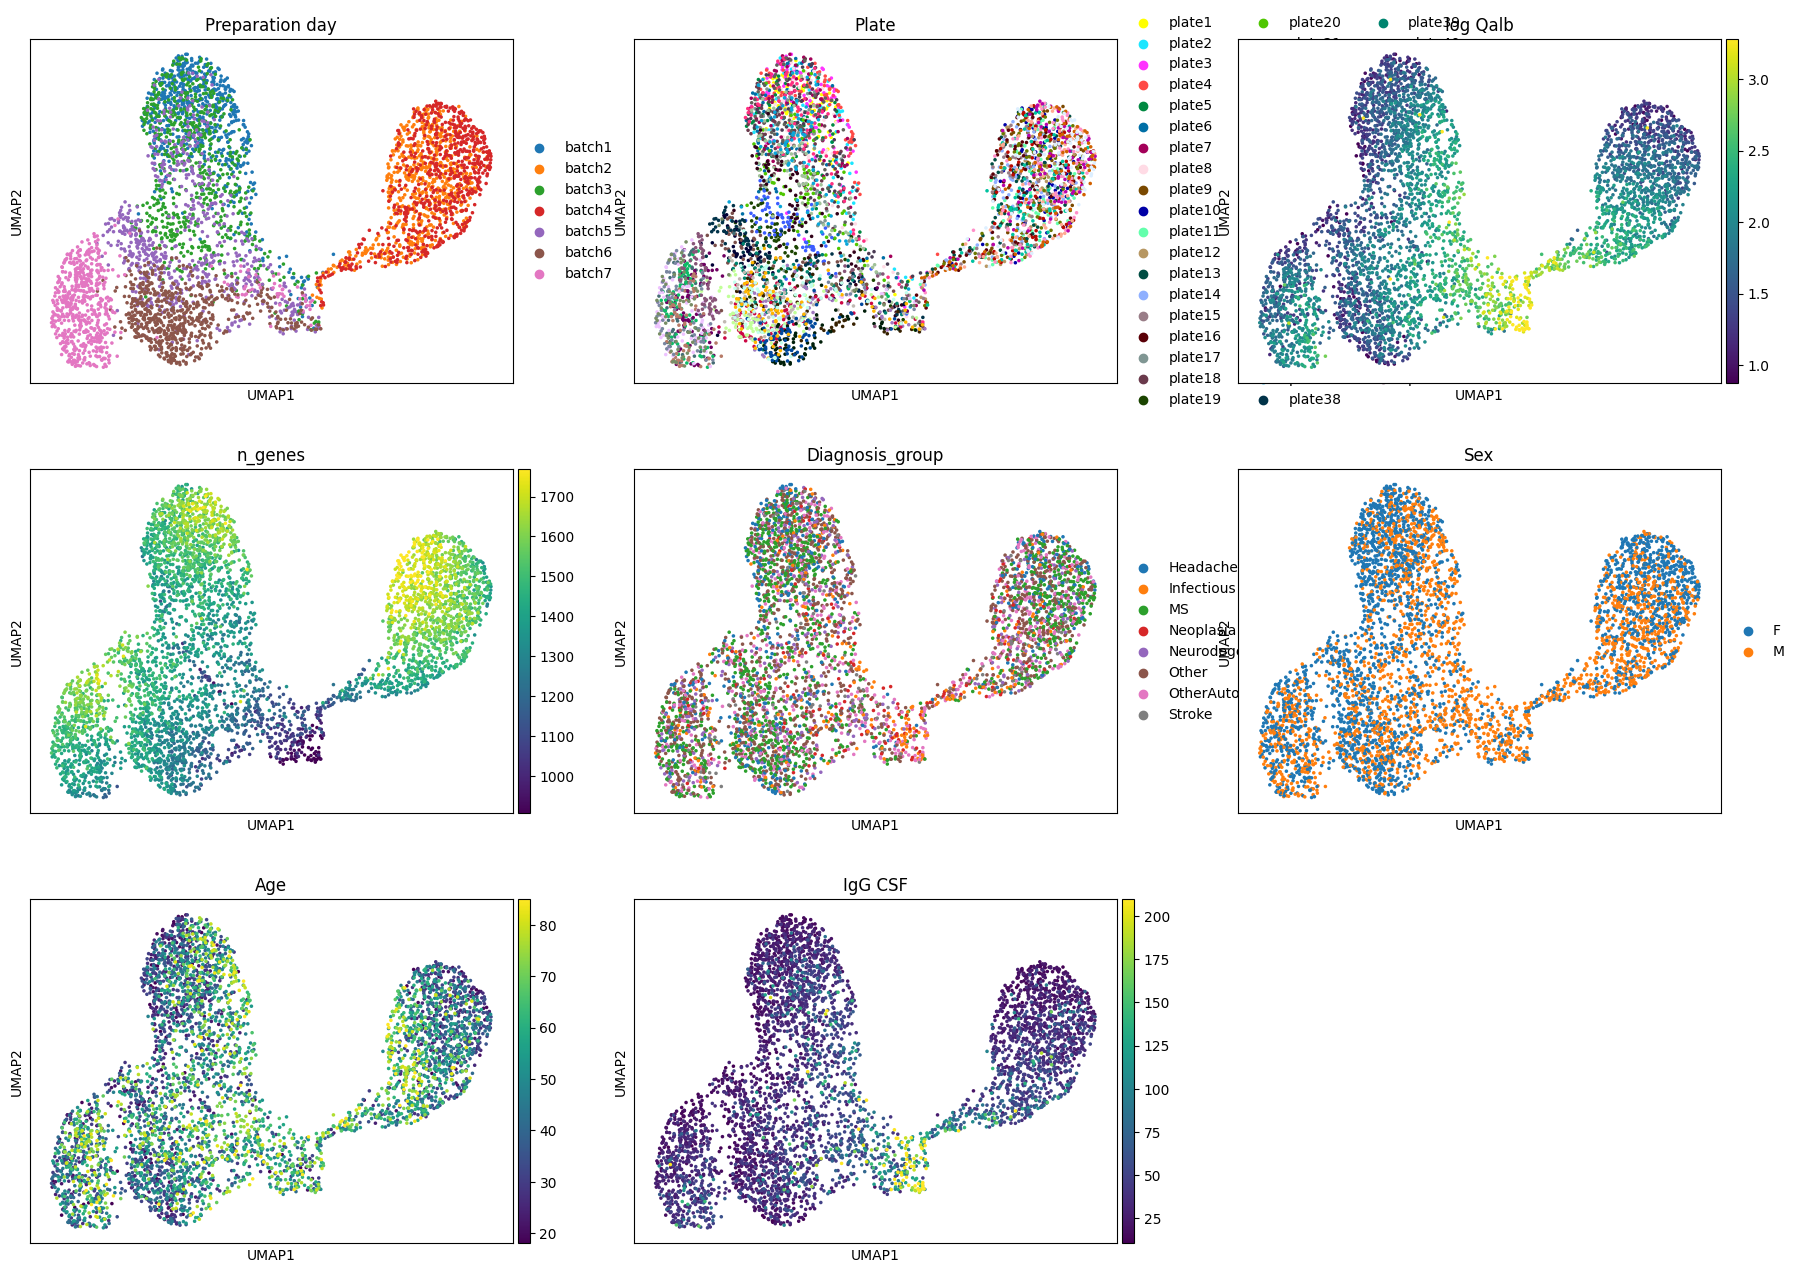

In [15]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Preparation day", "Plate", "log Qalb", "n_genes", "Diagnosis_group", "Sex", "Age",  "IgG CSF"], 
    vmin="p01", vmax="p99",
    ncols=3,
)

Let's look at the predicted detection probability for each protein, and compare it to the actual missingness.

In [16]:
dataset = model.adata_manager.create_torch_dataset()

data = {}
for key, value in dataset.data.items():
    if isinstance(value, np.ndarray):
        data[key] = torch.from_numpy(value).to(torch.float32)
    elif isinstance(value, pd.DataFrame):
        data[key] = torch.from_numpy(value.values).to(torch.float32)
    else:
        raise ValueError(f"Unexpected data type {type(value)}")

with torch.no_grad():
    inference_output, generative_output, loss = model.module(data)

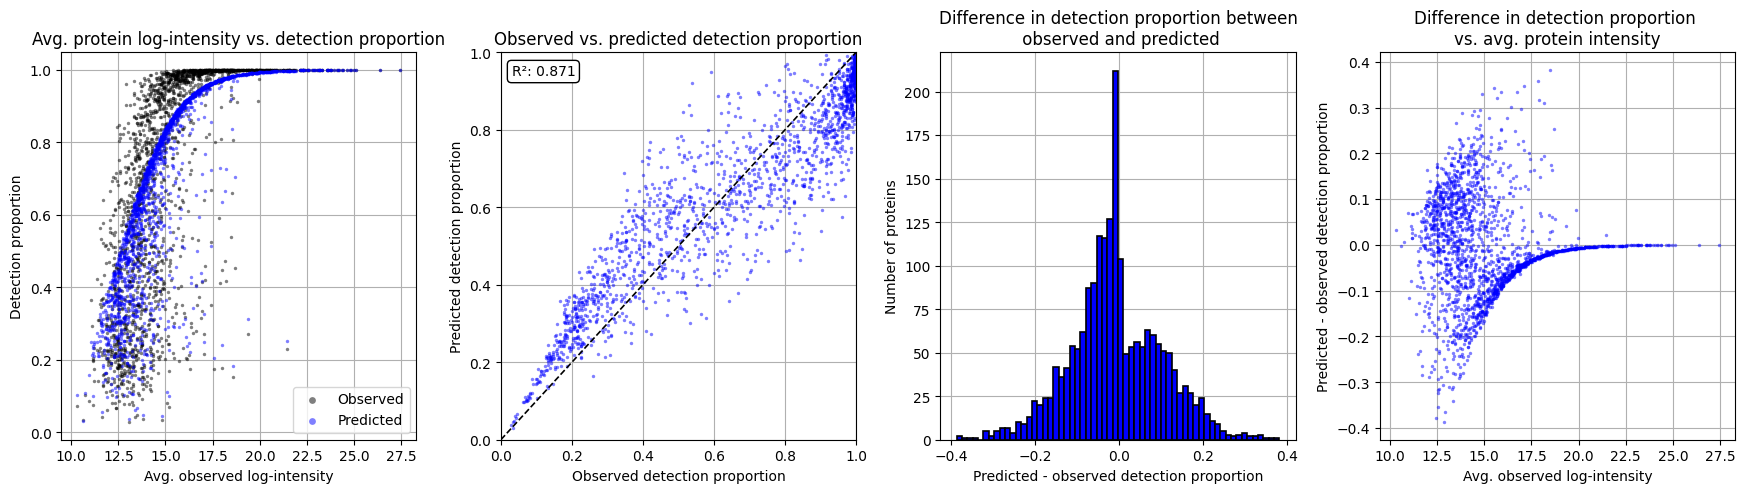

In [17]:
X_raw = adata.layers["missing_as_nan"]

avg_protein_intensities = np.nanmean(X_raw, axis=0)
obs_detection_proportion = 1 - np.mean(np.isnan(X_raw), axis=0)

pred_prob_detection = generative_output["prob_detection"].cpu().numpy()
pred_detection_proportion = pred_prob_detection.mean(axis=0)

fig, axes = plt.subplots(figsize=(18, 5), ncols=4)
fig.tight_layout(pad=3)

ax = axes[0]
ax.scatter(avg_protein_intensities, obs_detection_proportion, color="black", edgecolor="black", linewidth=0, s=6, alpha=.5, label="Observed")
ax.scatter(avg_protein_intensities, pred_detection_proportion, color="blue", edgecolor="black", linewidth=0, s=6, alpha=.5, label="Predicted")
ax.set_xlabel("Avg. observed log-intensity")
ax.set_ylabel("Detection proportion")
ax.set_title("Avg. protein log-intensity vs. detection proportion")
ax.legend()
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(markerscale=2)

ax = axes[1]
SS_res = np.sum((obs_detection_proportion - pred_detection_proportion) ** 2)
SS_tot = np.sum((obs_detection_proportion - np.mean(obs_detection_proportion)) ** 2)
r_squared = 1 - (SS_res / SS_tot)
ax.text(0.03, 0.94, f"R²: {r_squared:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"))
#pearson = pearsonr(obs_detection_proportion, pred_detection_proportion)
#ax.text(0.03, 0.90, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"))
ax.scatter(obs_detection_proportion, pred_detection_proportion, color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.plot([0, 1], [0, 1], color="black", linewidth=1.2, linestyle="--")
ax.set(xlim=[0, 1], ylim=[0, 1])
ax.set_xlabel("Observed detection proportion")
ax.set_ylabel("Predicted detection proportion")
ax.set_title("Observed vs. predicted detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
diff = pred_detection_proportion - obs_detection_proportion
ax.hist(diff, bins=60, color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_xlabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion between\n observed and predicted")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[3]
ax.scatter(avg_protein_intensities, diff, color="blue", edgecolor="black", linewidth=0, s=6, alpha=.5)
ax.set_xlabel("Avg. observed log-intensity")
ax.set_ylabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion \nvs. avg. protein intensity")
ax.grid(True)
ax.set_axisbelow(True)

Let's compare the "protein intensities" predicted by the model - specifically between the missing and present intensity entries in the original dataset for each protein.

In [18]:
mu = generative_output["px_mean"].cpu().numpy()

mu_present = mu.copy()
mu_present[np.isnan(X_raw)] = np.nan

mu_missing = mu.copy()
mu_missing[~np.isnan(X_raw)] = np.nan

In [19]:
print("Total averages:")
print(f"  Mean intensity (mu) of missing intensities: {np.nanmean(mu_missing):.2f}")
print(f"  Mean intensity (mu) of present intensities: {np.nanmean(mu_present):.2f}")

Total averages:
  Mean intensity (mu) of missing intensities: 11.47
  Mean intensity (mu) of present intensities: 15.73


Let's look at each protein individually. We'll first filter out proteins which do not contain any missing intensities. Note, the intensities are log intensities!

In [20]:
limited_coverage_proteins = np.isnan(mu_present).any(axis=0)
mu_present = mu_present[:, limited_coverage_proteins]
mu_missing = mu_missing[:, limited_coverage_proteins]

missing_intensity = np.nanmean(mu_missing, axis=0)
present_intensity = np.nanmean(mu_present, axis=0)

In [21]:
print("Protein averages:")
print(f"  Mean intensity (mu) of missing intensities: {np.mean(missing_intensity):.2f}")
print(f"  Mean intensity (mu) of present intensities: {np.mean(present_intensity):.2f}")

Protein averages:
  Mean intensity (mu) of missing intensities: 13.18
  Mean intensity (mu) of present intensities: 14.18


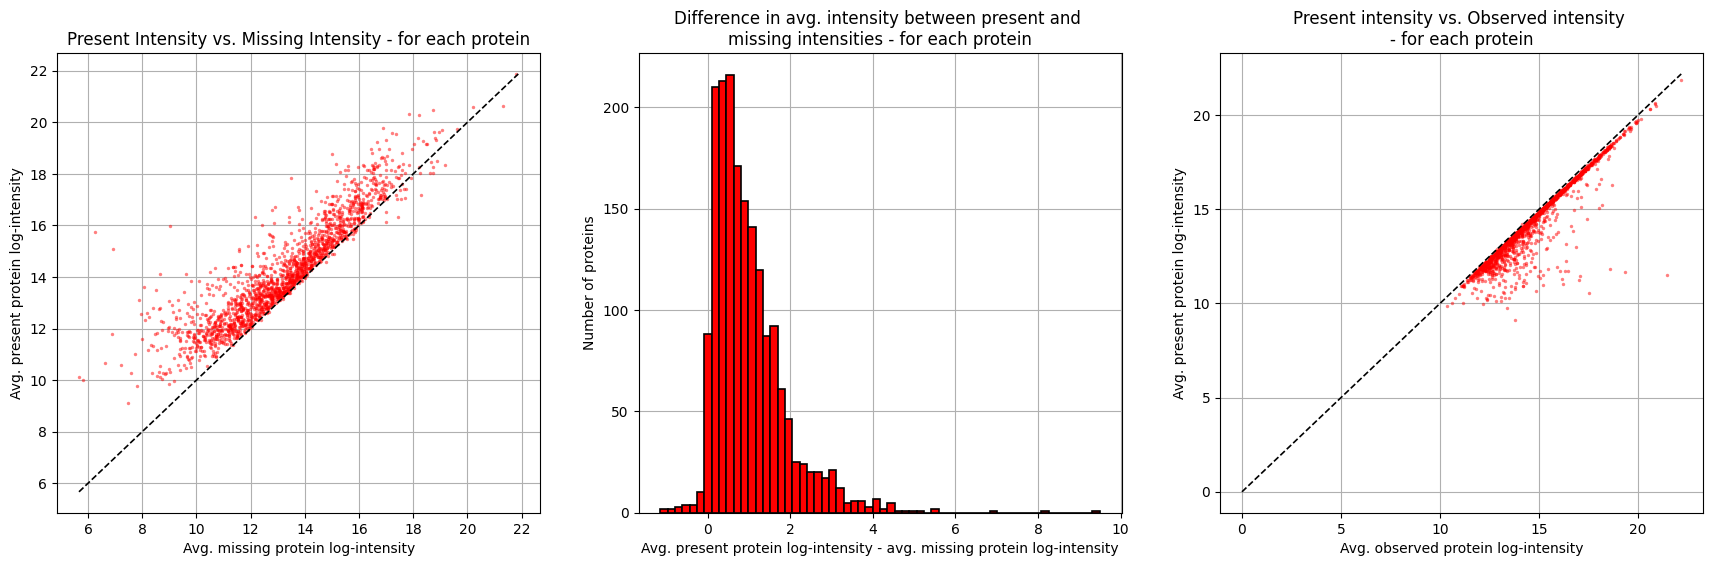

In [22]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
fig.tight_layout(pad=4)

ax = axes[0]
min_v = min(present_intensity.min(), missing_intensity.min())
max_v = max(present_intensity.max(), missing_intensity.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--")
ax.scatter(missing_intensity, present_intensity, color="red", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_xlabel("Avg. missing protein log-intensity")
ax.set_ylabel("Avg. present protein log-intensity")
ax.set_title("Present Intensity vs. Missing Intensity - for each protein")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
difference = present_intensity - missing_intensity
ax.hist(difference, bins=60, color="red", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_xlabel("Avg. present protein log-intensity - avg. missing protein log-intensity")
ax.set_title("Difference in avg. intensity between present and \nmissing intensities - for each protein")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
observed_intensity = np.nanmean(X_raw, axis=0)
observed_intensity = observed_intensity[limited_coverage_proteins]
ax.plot([0, observed_intensity.max()], [0, observed_intensity.max()], color="black", linewidth=1.2, linestyle="--")
ax.scatter(observed_intensity, present_intensity, color="red", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_xlabel("Avg. observed protein log-intensity")
ax.set_ylabel("Avg. present protein log-intensity")
ax.set_title("Present intensity vs. Observed intensity \n- for each protein")
ax.grid(True)
ax.set_axisbelow(True)

## protDP - comparison

Let's compare PROTVI with [protDP](https://mengbo-li.github.io/protDP/index.html). First, we'll fit protDP to the data.

In [23]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [24]:
%%R -i adata
library(protDP)

X <- assay(adata, "missing_as_nan")
dpcfit <- dpc(X)

In [25]:
dpc_result = robjects.r("dpcfit")

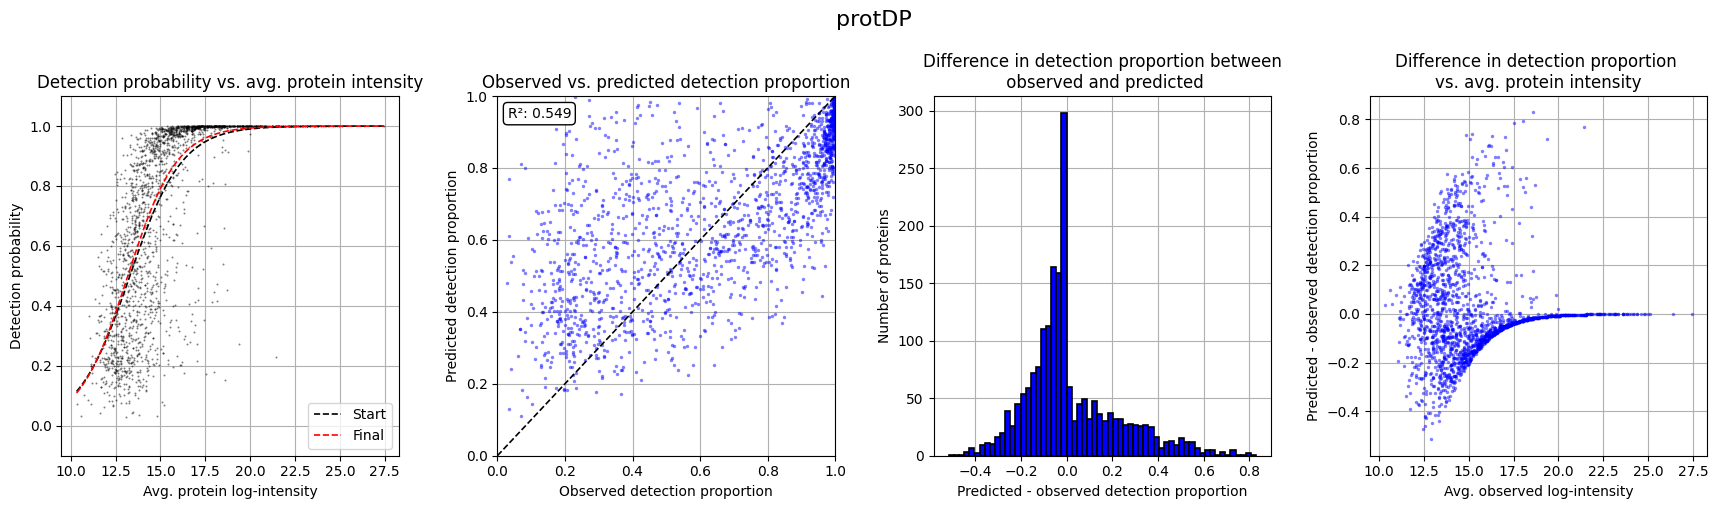

In [26]:
beta = dpc_result["beta"]
beta_start = dpc_result["betaStart"]

sigmoid = lambda x: 1 / (1 + np.exp(-x))

fig, axes = plt.subplots(figsize=(18, 5), ncols=4)
fig.tight_layout(pad=4)
fig.suptitle("protDP", fontsize=16, y=1.05)

ax = axes[0]
min_intensity = np.nanmin(avg_protein_intensities)
max_intensity = np.nanmax(avg_protein_intensities)
x = np.linspace(min_intensity, max_intensity, 100)
y1 = sigmoid(beta_start[0] + beta_start[1] * x)
y2 = sigmoid(beta[0] + beta[1] * x)
ax.plot(x, y1, color="black", linewidth=1.2, linestyle="--", label="Start")
ax.plot(x, y2, color="red", linewidth=1.2, linestyle="--", label="Final")
ax.scatter(avg_protein_intensities, obs_detection_proportion, color="black", linewidth=0, s=2, alpha=0.5)
ax.set_xlabel("Avg. protein log-intensity")
ax.set_ylabel("Detection probability")
ax.set_title("Detection probability vs. avg. protein intensity")
ax.set_ylim([-0.1, 1.1])
ax.grid(True)
ax.legend()
ax.set_axisbelow(True)

ax = axes[1]
dpc_detection_prop = sigmoid(beta[0] + beta[1] * avg_protein_intensities)
SS_res = np.sum((obs_detection_proportion - dpc_detection_prop) ** 2)
SS_tot = np.sum((obs_detection_proportion - np.mean(obs_detection_proportion)) ** 2)
r_squared = 1 - (SS_res / SS_tot)
ax.text(0.03, 0.94, f"R²: {r_squared:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"))
ax.scatter(obs_detection_proportion, dpc_detection_prop, color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.plot([0, 1], [0, 1], color="black", linewidth=1.2, linestyle="--")
ax.set(xlim=[0, 1], ylim=[0, 1])
ax.set_xlabel("Observed detection proportion")
ax.set_ylabel("Predicted detection proportion")
ax.set_title("Observed vs. predicted detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
diff = dpc_detection_prop - obs_detection_proportion
ax.hist(diff, bins=60, color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_xlabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion between\n observed and predicted")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[3]
ax.scatter(avg_protein_intensities, diff, color="blue", edgecolor="black", linewidth=0, s=6, alpha=.5)
ax.set_xlabel("Avg. observed log-intensity")
ax.set_ylabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion \nvs. avg. protein intensity")
ax.grid(True)
ax.set_axisbelow(True)

Let's compare the results of the two methods:

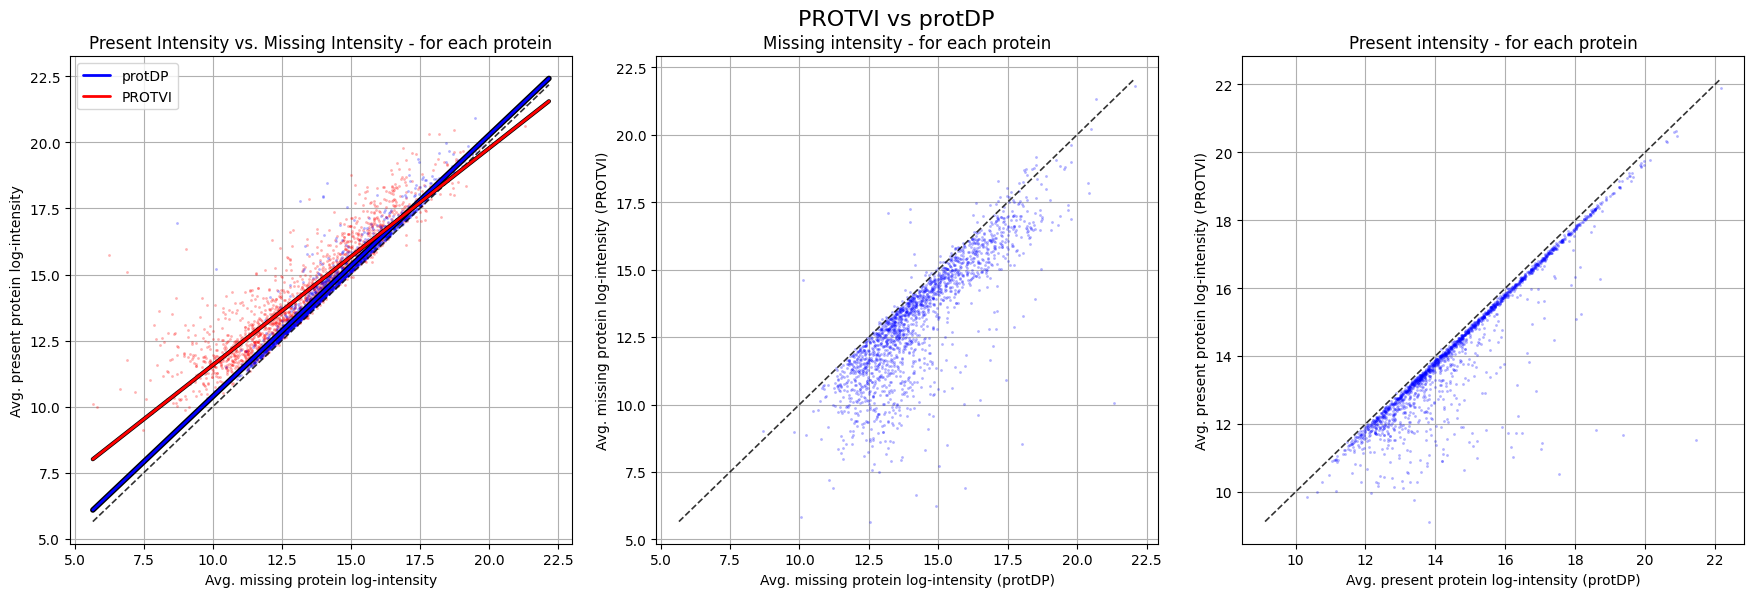

In [27]:
dpc_mu_miss = dpc_result["mu_mis"][limited_coverage_proteins]
dpc_mu_obs = dpc_result["mu_obs"][limited_coverage_proteins]

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
fig.tight_layout(pad=3)
fig.suptitle("PROTVI vs protDP", fontsize=16, y=1)

ax = axes[0]
ax.scatter(missing_intensity, present_intensity, color="red", edgecolor="black", linewidth=0, s=4, alpha=.3)
ax.scatter(dpc_mu_miss, dpc_mu_obs, color="blue", edgecolor="purple", linewidth=0, s=4, alpha=.3)
min_v = min(present_intensity.min(), missing_intensity.min(), dpc_mu_miss.min(), dpc_mu_obs.min())
max_v = max(present_intensity.max(), missing_intensity.max(), dpc_mu_miss.max(), dpc_mu_obs.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--", alpha=.8)

lm.fit(dpc_mu_miss.reshape(-1, 1), dpc_mu_obs.reshape(-1, 1))
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="black", linewidth=4, linestyle="-", solid_capstyle="round",)
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="blue", linewidth=2, linestyle="-", solid_capstyle="round", label="protDP")

lm.fit(missing_intensity.reshape(-1, 1), present_intensity.reshape(-1, 1))
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="black", linewidth=3, linestyle="-", solid_capstyle="round")
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="red", linewidth=2, linestyle="-", solid_capstyle="round", label="PROTVI")

ax.set_xlabel("Avg. missing protein log-intensity")
ax.set_ylabel("Avg. present protein log-intensity")
ax.set_title("Present Intensity vs. Missing Intensity - for each protein")
ax.legend(markerscale=2)
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.scatter(dpc_mu_miss, missing_intensity, color="blue", edgecolor="purple", linewidth=0, s=4, alpha=.3)
min_v = min(dpc_mu_miss.min(), missing_intensity.min())
max_v = max(dpc_mu_miss.max(), missing_intensity.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--", alpha=.8)
ax.set_xlabel("Avg. missing protein log-intensity (protDP)")
ax.set_ylabel("Avg. missing protein log-intensity (PROTVI)")
ax.set_title("Missing intensity - for each protein")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
ax.scatter(dpc_mu_obs, present_intensity, color="blue", edgecolor="purple", linewidth=0, s=4, alpha=.3)
min_v = min(dpc_mu_obs.min(), present_intensity.min())
max_v = max(dpc_mu_obs.max(), present_intensity.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--", alpha=.8)
ax.set_xlabel("Avg. present protein log-intensity (protDP)")
ax.set_ylabel("Avg. present protein log-intensity (PROTVI)")
ax.set_title("Present intensity - for each protein")
ax.grid(True)
ax.set_axisbelow(True)
